In [1]:
%matplotlib inline
from __future__ import print_function,division
import os, sys, datetime, glob
from collections import OrderedDict
from functools import partial
import numpy as np

import matplotlib.pyplot as plt

try:
    from importlib import reload # Python 3
except ImportError:
    pass

import torch
print(torch.__version__)

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import trainimagesource, trainutils, pytorchutils, pytorchnet

plt.rcParams['image.cmap'] = 'Set1'
plt.rcParams['image.interpolation']='none'

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
   
imwidth = 256
imheight = 256
numimgs = 500
numClasses=2   

learningRate=1e-4
trainSteps=200
batchSize=20
filters=(16, 32, 64, 128, 256)
strides=( 1,  2,  2,   2,   2)
resunits=2
kernelsize=3

0.4.0


2 {0, 1, 2}


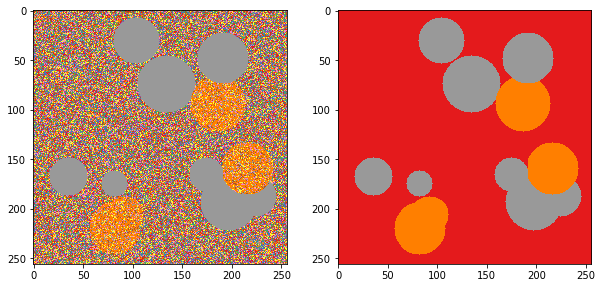

In [2]:
def createTestImage(width,height,numObjs=12,radMax=30,numSegClasses=5):
    '''
    Return a noisy 2D image with `numObj' circles and a 2D mask image. The maximum radius of the circles is
    given as `radMax'. The mask will have `numSegClasses' number of classes for segmentations labeled 
    sequentially from 1, plus a background class represented as 0.
    '''
    image=np.zeros((width,height))
    
    for i in range(numObjs):
        x=np.random.randint(radMax,width-radMax)
        y=np.random.randint(radMax,height-radMax)
        rad=np.random.randint(10,radMax)
        spy,spx = np.ogrid[-x:width-x,-y:height-y]
        circle=(spx*spx+spy*spy)<=rad*rad
        image[circle]=np.ceil(np.random.random()*numSegClasses)
    
    brightimage=image # (image>0)*(image*0.5+0.5)
    
    norm=np.random.uniform(0,numSegClasses,size=image.shape)
    noisyimage=np.maximum(brightimage,norm).astype(np.float32)
    
    finalimage=noisyimage/noisyimage.max()
    labels=image.astype(np.int32)
    
    assert np.all((image>0)==(labels>0)), 'Not all circles were assigned a class in labels!'
    
    return finalimage,labels


def plotPair(im1,im2):
    '''Convenience function for plotting two images side-by-side.'''
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(im1)
    ax[1].imshow(im2)

    
im,mask=createTestImage(imwidth,imheight,numSegClasses=numClasses)
print(numClasses,set(mask.flatten().tolist()))
plotPair(im,mask)

(500, 256, 256, 1) (500, 256, 256)
float32 (1, 1, 256, 256) int32 (1, 1, 256, 256)


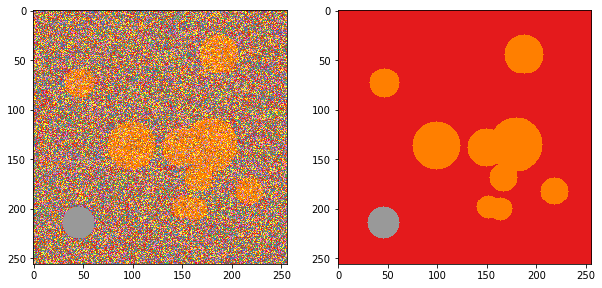

In [3]:
dataset=[createTestImage(imwidth,imheight,numSegClasses=numClasses) for _ in range(numimgs)]
imgin=np.concatenate([(d[0],) for d in dataset])[...,np.newaxis]
maskin=np.concatenate([(d[1],) for d in dataset])

print(imgin.shape,maskin.shape)
src=trainimagesource.TrainImageSource(imgin,maskin,[pytorchutils.convertAug])

im,mask=src.getBatch(1)
print(im.dtype,im.shape,mask.dtype,mask.shape)
plotPair(im[0,0],mask[0,0])

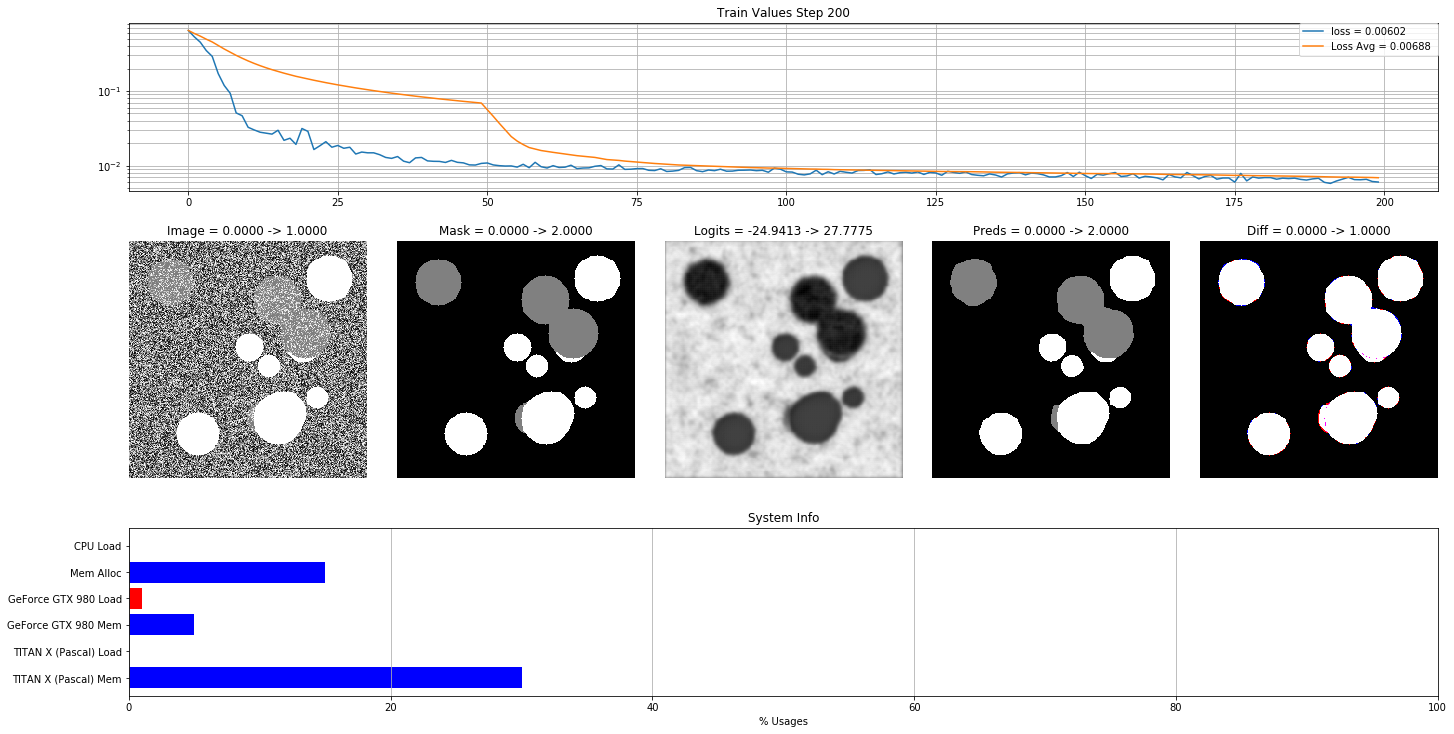

In [4]:
pytorchnet=reload(pytorchnet)
pytorchutils=reload(pytorchutils)
class UnetMgrNB(pytorchutils.SegmentMgr):
    lossavgs=[]
    steplosses=[]
    lossavglen=50
    fig=None
        
    def updateStep(self,step,steploss):
        self.steplosses.append(steploss)
        self.lossavgs.append(np.average(self.steplosses[-self.lossavglen:]))
        self.log('Loss Average:',self.lossavgs[-1])
        
        if step<10 or step%5==0:
            images,masks=self.traininputs
            logits,preds=self.netoutputs

            mask=self.toNumpy(masks[0,0])
            preds=self.toNumpy(preds[0])

            imgmap=OrderedDict([
                ('Image',self.toNumpy(images[0,0])),
                ('Mask',mask),
                ('Logits',self.toNumpy(logits[0,0])),
                ('Preds',preds),
                ('Diff',np.dstack([mask>0,(mask==preds)*(mask>0)*(preds>0),preds>0]).astype(np.float32)),
            ])

            graphs={'loss':self.steplosses,'Loss Avg':self.lossavgs}
        
            self.fig,ax=trainutils.plotGraphImages('Train Values Step %i'%(step,),graphs,imgmap,fig=self.fig)
            clear_output(wait=True)
            display(plt.gcf())

net=pytorchnet.Unet2D(1,numClasses+1,filters,strides,kernelsize,resunits)

mgr=UnetMgrNB(net)

# test=mgr.infer(src.getBatch(1))
# print(test[0][0].shape)

mgr.train(src.getAsyncFunc(batchSize),trainSteps)
clear_output(wait=True)

In [5]:
# pytorchnet=reload(pytorchnet)
# pytorchutils=reload(pytorchutils)

# scale=1000
# im,mask=src.getBatch(1)

# mask=torch.tensor(mask)


# mask1h=pytorchnet.oneHot2D(mask,numClasses+1)
# mask1h=mask1h[:,0].permute(0,3,1,2)*scale

# plotPair(im[0,0],mask[0,0])
# for i in range(mask1h.shape[1]):
#     plt.figure()
#     plotPair(mask[0,0]==i,mask1h[0,i])

#     assert np.all((mask[0,0]==i).float()==mask1h[0,i]/scale)


# print(mask1h.shape,mask.shape)

# loss=pytorchnet.MulticlassDiceLoss(False)
# print(0,loss(mask1h,mask))
# print(1,loss(1-mask1h,mask))

# loss=pytorchnet.MulticlassDiceLoss(True)
# print(0,loss(mask1h[:,1:],mask))
# print(1,loss(1-mask1h[:,1:],mask))

In [6]:
# pytorchnet=reload(pytorchnet)

# n=torch.zeros((6,6))
# n[1:5,1:5]=1
# n[2:4,2:4]=2
# # print(n)
# oh=pytorchnet.oneHot2D(n[np.newaxis,np.newaxis],3)
# # print(oh[...,0])
# # print(oh[...,1])
# # print(oh[...,2])

# fakelogits=oh[:,0].permute(0,3,1,2) # BCHWN -> BNHW
# groundtruth=n[np.newaxis,np.newaxis]

# print(n.shape,oh.shape,groundtruth.shape,fakelogits.shape)


# loss=pytorchnet.MulticlassDiceLoss(3)
# print(loss(fakelogits,groundtruth,1e-15))